# 🏥 Function Health - Arivale Patient-Level Analysis

This notebook analyzes patient-level data for matched tests between Function Health and Arivale.

## 📋 Analysis Goals:
1. Count unique patients (public_client_id) that have each matching test
2. Analyze longitudinal patterns - distribution of test collections over time
3. Visualize patient coverage and test frequency patterns

## 📁 Data Sources:
- Mapping results: `../data/function_health/function_health_arivale_outer_join.csv`
- Chemistry data: `/procedure/data/local_data/ARIVALE_SNAPSHOTS/chemistries.tsv`

## 1️⃣ Import Libraries and Setup

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2️⃣ Load Arivale Chemistry Data

In [2]:
# Load the Arivale chemistry data
chemistry_file = '/procedure/data/local_data/ARIVALE_SNAPSHOTS/chemistries.tsv'

try:
    # Load the Arivale chemistry data
    chemistry_df = pd.read_csv(chemistry_file, sep='\t', low_memory=False, comment='#')
    print(f"✅ Loaded chemistry data: {len(chemistry_df):,} records")
    print(f"👥 Unique patients: {chemistry_df['public_client_id'].nunique():,}")
    
    # Display column info
    print(f"\n📋 Total columns: {len(chemistry_df.columns)}")
    print("\n🔍 First 20 columns:")
    print(chemistry_df.columns[:20].tolist())
    
except Exception as e:
    print(f"❌ Error loading chemistry data: {e}")

✅ Loaded chemistry data: 11,167 records
👥 Unique patients: 4,881

📋 Total columns: 140

🔍 First 20 columns:
['public_client_id', 'vendor', 'vendor_observation_id', 'observation_id', 'reflexive', 'fasting', 'days_in_program', 'days_since_first_call', 'days_since_first_draw', 'month', 'weekday', 'season', 'A/G RATIO', 'ADIPONECTIN, SERUM', 'ALAT (SGPT)', 'ALBUMIN', 'ALKALINE PHOSPHATASE', 'ANTIOXID CAP, TOTAL', 'ARACHIDONIC ACID', 'ARSENIC, BLOOD']


## 3️⃣ Analyze Test Columns

In [3]:
# Analyze chemistry data directly without mapping complexities
print("📊 Analyzing chemistry data directly...")

# Get all test columns from chemistry data (exclude metadata columns)
metadata_cols = ['public_client_id', 'vendor', 'vendor_observation_id', 'observation_id', 
                 'reflexive', 'fasting', 'days_in_program', 'days_since_first_call', 
                 'days_since_first_draw', 'month', 'weekday', 'season', 'collection_date',
                 'sample_id', 'lab_id', 'created_at', 'updated_at']

# Get all columns that are actual tests
all_test_columns = [col for col in chemistry_df.columns if col not in metadata_cols]

print(f"✅ Found {len(all_test_columns)} test columns in chemistry data")
print(f"👥 Total unique patients: {chemistry_df['public_client_id'].nunique():,}")
print(f"📊 Total observations: {len(chemistry_df):,}")

# Show sample of test columns
print("\n🔍 Sample test columns:")
for i, col in enumerate(all_test_columns[:20]):
    print(f"  {i+1}. {col}")
    
if len(all_test_columns) > 20:
    print(f"  ... and {len(all_test_columns) - 20} more tests")

📊 Analyzing chemistry data directly...
✅ Found 128 test columns in chemistry data
👥 Total unique patients: 4,881
📊 Total observations: 11,167

🔍 Sample test columns:
  1. A/G RATIO
  2. ADIPONECTIN, SERUM
  3. ALAT (SGPT)
  4. ALBUMIN
  5. ALKALINE PHOSPHATASE
  6. ANTIOXID CAP, TOTAL
  7. ARACHIDONIC ACID
  8. ARSENIC, BLOOD
  9. ASAT (SGOT)
  10. BASOPHILS
  11. BASOPHILS ABSOLUTE
  12. BILIRUBIN, DIRECT
  13. BILIRUBIN, INDIRECT
  14. BILIRUBIN, TOTAL
  15. BUN/CREAT RATIO
  16. CALCIUM
  17. CARBON DIOXIDE (CO2)
  18. CHLORIDE
  19. CHOLESTEROL, TOTAL
  20. COPPER, RBC
  ... and 108 more tests


## 4️⃣ Calculate Patient Counts per Test

In [4]:
# Calculate patient counts for each test
import os

# Initialize output directory
output_dir = '/home/ubuntu/data/function_health'
os.makedirs(output_dir, exist_ok=True)

print("Calculating patient counts for each test...")

# Check dependencies
if 'chemistry_df' not in locals():
    print("ERROR: Please run cell 4 first to load chemistry_df")
elif 'all_test_columns' not in locals():
    print("ERROR: Please run cell 6 first to identify test columns")
else:
    patient_counts = []
    
    for test in all_test_columns:
        # Get non-null values for this test
        non_null_data = chemistry_df[chemistry_df[test].notna()]
        
        if len(non_null_data) > 0:
            unique_patients = non_null_data['public_client_id'].nunique()
            total_measurements = len(non_null_data)
            avg_per_patient = total_measurements / unique_patients if unique_patients > 0 else 0
            
            patient_counts.append({
                'Test Name': test,
                'Unique Patients': unique_patients,
                'Total Measurements': total_measurements,
                'Avg Measurements per Patient': round(avg_per_patient, 2)
            })
    
    # Create DataFrame and sort by patient count
    patient_counts_df = pd.DataFrame(patient_counts)
    patient_counts_df = patient_counts_df.sort_values('Unique Patients', ascending=False)
    
    # Save to CSV
    patient_counts_df.to_csv(os.path.join(output_dir, 'patient_counts_by_test_direct.csv'), index=False)
    
    # Display summary statistics
    print(f"\nAnalyzed {len(patient_counts)} tests with data")
    print(f"Tests with most patients: {patient_counts_df.iloc[0]['Test Name']} ({patient_counts_df.iloc[0]['Unique Patients']} patients)")
    print(f"Tests with fewest patients: {patient_counts_df.iloc[-1]['Test Name']} ({patient_counts_df.iloc[-1]['Unique Patients']} patients)")
    print(f"Average patients per test: {patient_counts_df['Unique Patients'].mean():.0f}")
    print(f"\nResults saved to {os.path.join(output_dir, 'patient_counts_by_test_direct.csv')}")

Calculating patient counts for each test...

Analyzed 128 tests with data
Tests with most patients: A/G RATIO (4881 patients)
Tests with fewest patients: leptin (251 patients)
Average patients per test: 2999

Results saved to /home/ubuntu/data/function_health/patient_counts_by_test_direct.csv


In [5]:
# Display top 20 tests by patient count
print("Top 20 Tests by Unique Patient Count:")
print(patient_counts_df.head(20))

# Display tests with very few patients
print("\n\nTests with fewer than 100 unique patients:")
low_count_tests = patient_counts_df[patient_counts_df['Unique Patients'] < 100]
print(low_count_tests)

Top 20 Tests by Unique Patient Count:
               Test Name  Unique Patients  Total Measurements  \
0              A/G RATIO             4881               11080   
2            ALAT (SGPT)             4881               11080   
3                ALBUMIN             4881               11080   
4   ALKALINE PHOSPHATASE             4881               11080   
13      BILIRUBIN, TOTAL             4881               11080   
14       BUN/CREAT RATIO             4881               11080   
15               CALCIUM             4881               11080   
8            ASAT (SGOT)             4881               11080   
20   CREATININE ENZ, SER             4881               11080   
28              FERRITIN             4881                9493   
30             GFR, MDRD             4881               11079   
21  CRP HIGH SENSITIVITY             4881               11083   
17              CHLORIDE             4881               11080   
18    CHOLESTEROL, TOTAL             4881           

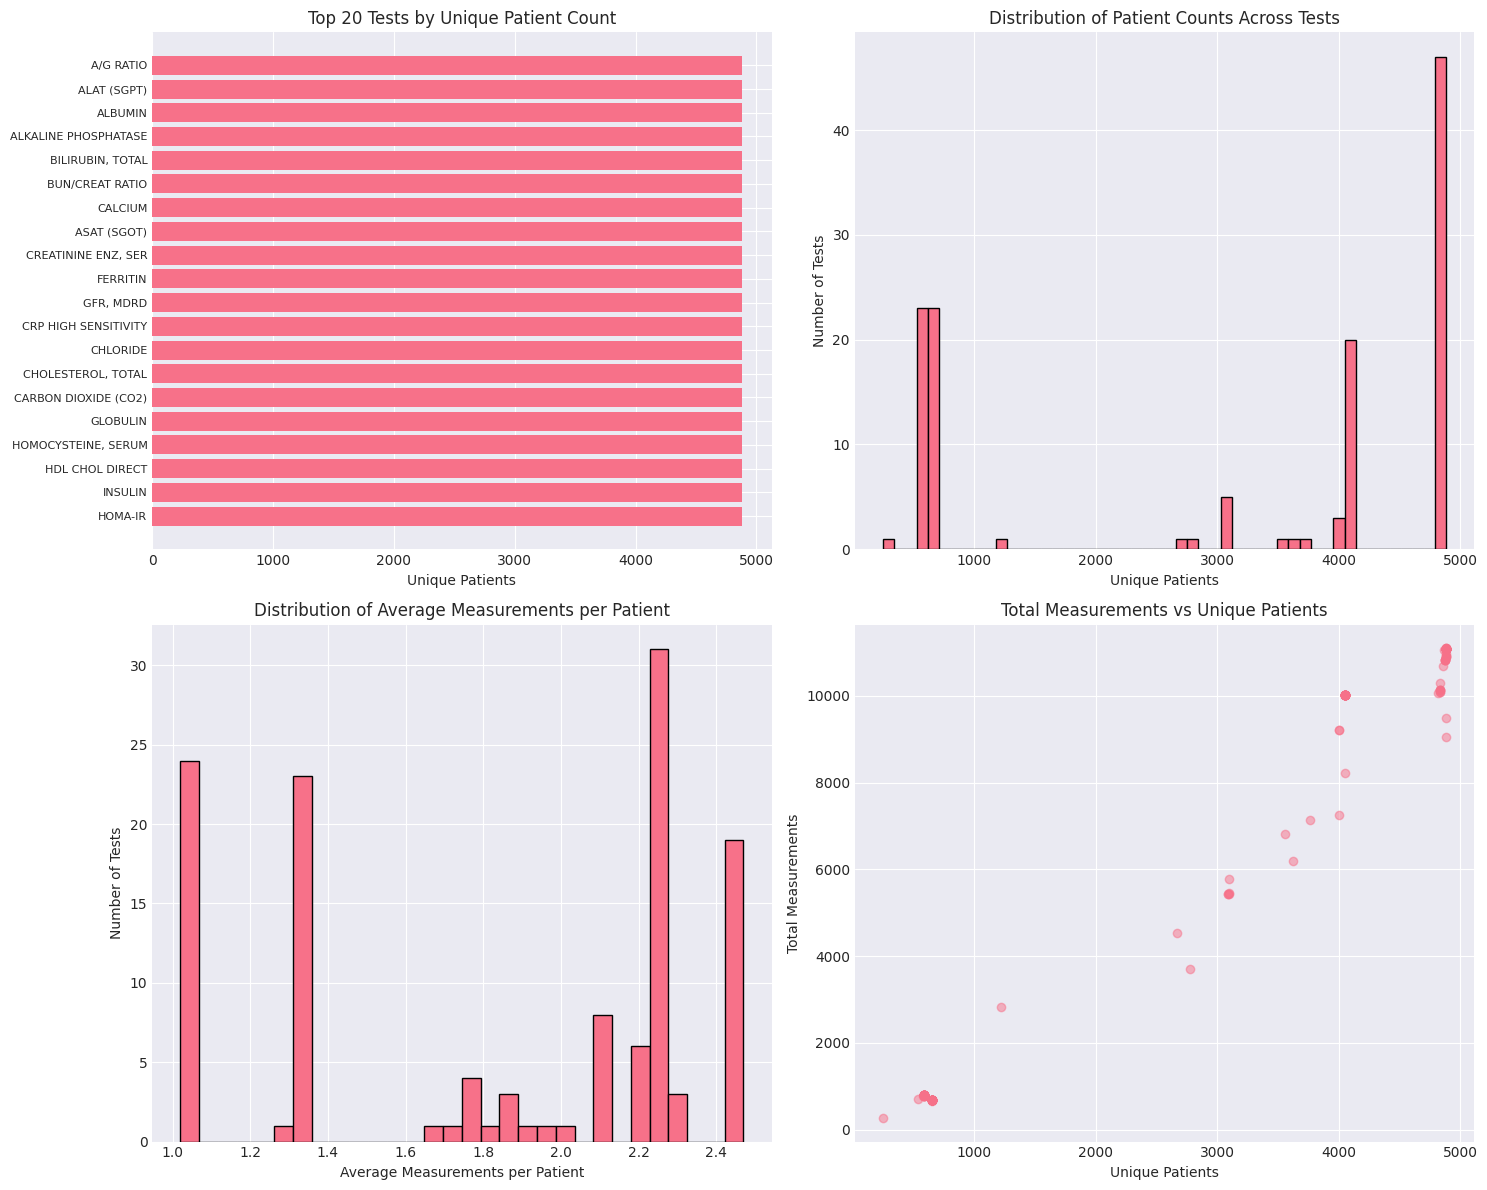

Visualization saved to /home/ubuntu/data/function_health/patient_count_visualizations.png


In [6]:
# Create visualization of patient counts
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Bar plot of top 20 tests
ax1 = axes[0, 0]
top_20 = patient_counts_df.head(20)
ax1.barh(range(len(top_20)), top_20['Unique Patients'])
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels(top_20['Test Name'], fontsize=8)
ax1.set_xlabel('Unique Patients')
ax1.set_title('Top 20 Tests by Unique Patient Count')
ax1.invert_yaxis()

# 2. Distribution of patient counts
ax2 = axes[0, 1]
ax2.hist(patient_counts_df['Unique Patients'], bins=50, edgecolor='black')
ax2.set_xlabel('Unique Patients')
ax2.set_ylabel('Number of Tests')
ax2.set_title('Distribution of Patient Counts Across Tests')

# 3. Average measurements per patient distribution
ax3 = axes[1, 0]
ax3.hist(patient_counts_df['Avg Measurements per Patient'], bins=30, edgecolor='black')
ax3.set_xlabel('Average Measurements per Patient')
ax3.set_ylabel('Number of Tests')
ax3.set_title('Distribution of Average Measurements per Patient')

# 4. Scatter plot: Total Measurements vs Unique Patients
ax4 = axes[1, 1]
ax4.scatter(patient_counts_df['Unique Patients'], 
           patient_counts_df['Total Measurements'], 
           alpha=0.5)
ax4.set_xlabel('Unique Patients')
ax4.set_ylabel('Total Measurements')
ax4.set_title('Total Measurements vs Unique Patients')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'patient_count_visualizations.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Visualization saved to {os.path.join(output_dir, 'patient_count_visualizations.png')}")

In [7]:
# Analyze longitudinal patterns
print("Analyzing longitudinal patterns...")

# Make sure we have required data
if 'patient_counts_df' not in locals():
    print("ERROR: Please run cell 8 first to create patient_counts_df")
elif 'chemistry_df' not in locals():
    print("ERROR: Please run cell 4 first to load chemistry_df")
else:
    # For top 10 tests, analyze how many times patients were tested
    top_10_tests = patient_counts_df.head(10)['Test Name'].tolist()
    
    longitudinal_analysis = []
    
    for test in top_10_tests:
        # Get non-null values for this test
        test_data = chemistry_df[chemistry_df[test].notna()]
        
        # Count measurements per patient
        patient_measurement_counts = test_data.groupby('public_client_id').size()
        
        # Calculate statistics
        stats = {
            'Test': test,
            'Patients with 1 measurement': (patient_measurement_counts == 1).sum(),
            'Patients with 2 measurements': (patient_measurement_counts == 2).sum(),
            'Patients with 3+ measurements': (patient_measurement_counts >= 3).sum(),
            'Max measurements per patient': patient_measurement_counts.max(),
            'Median measurements per patient': patient_measurement_counts.median()
        }
        
        longitudinal_analysis.append(stats)
    
    # Create DataFrame from results
    longitudinal_df = pd.DataFrame(longitudinal_analysis)
    print("\nLongitudinal Analysis for Top 10 Tests:")
    print(longitudinal_df)

Analyzing longitudinal patterns...

Longitudinal Analysis for Top 10 Tests:
                   Test  Patients with 1 measurement  \
0             A/G RATIO                         1991   
1           ALAT (SGPT)                         1991   
2               ALBUMIN                         1991   
3  ALKALINE PHOSPHATASE                         1991   
4      BILIRUBIN, TOTAL                         1991   
5       BUN/CREAT RATIO                         1991   
6               CALCIUM                         1991   
7           ASAT (SGOT)                         1991   
8   CREATININE ENZ, SER                         1991   
9              FERRITIN                         2566   

   Patients with 2 measurements  Patients with 3+ measurements  \
0                          1200                           1690   
1                          1200                           1690   
2                          1200                           1690   
3                          1200            

In [8]:
# Analyze time patterns using days_since_first_draw
print("Analyzing temporal patterns...")

# Make sure we have patient_counts_df
if 'patient_counts_df' not in locals():
    print("ERROR: Please run cell 8 first to create patient_counts_df")
else:
    # Get top 10 tests from patient_counts_df
    top_10_tests = patient_counts_df.head(10)['Test Name'].tolist()
    
    # Look at a specific common test
    test_name = top_10_tests[0]  # Use the most common test
    test_data = chemistry_df[chemistry_df[test_name].notna()].copy()
    
    # Convert days_since_first_draw to numeric
    test_data['days_since_first_draw'] = pd.to_numeric(test_data['days_since_first_draw'], errors='coerce')
    
    # Group patients by number of measurements
    patient_counts = test_data.groupby('public_client_id').size()
    single_measurement_patients = patient_counts[patient_counts == 1].index
    multiple_measurement_patients = patient_counts[patient_counts > 1].index
    
    print(f"\nFor test '{test_name}':")
    print(f"Patients with single measurement: {len(single_measurement_patients)}")
    print(f"Patients with multiple measurements: {len(multiple_measurement_patients)}")
    
    # For patients with multiple measurements, analyze time between tests
    if len(multiple_measurement_patients) > 0:
        multi_test_data = test_data[test_data['public_client_id'].isin(multiple_measurement_patients)]
        
        # Calculate time gaps between measurements for each patient
        time_gaps = []
        for patient_id in multiple_measurement_patients[:100]:  # Sample first 100 patients
            patient_data = multi_test_data[multi_test_data['public_client_id'] == patient_id].sort_values('days_since_first_draw')
            if len(patient_data) > 1:
                gaps = patient_data['days_since_first_draw'].diff().dropna()
                time_gaps.extend(gaps.tolist())
        
        if time_gaps:
            print(f"\nTime between measurements (days):")
            print(f"Mean: {np.mean(time_gaps):.1f}")
            print(f"Median: {np.median(time_gaps):.1f}")
            print(f"Min: {np.min(time_gaps):.1f}")
            print(f"Max: {np.max(time_gaps):.1f}")

Analyzing temporal patterns...

For test 'A/G RATIO':
Patients with single measurement: 1991
Patients with multiple measurements: 2890

Time between measurements (days):
Mean: 198.8
Median: 189.0
Min: 83.0
Max: 529.0


Calculating time gaps between measurements for all mapped tests...
Processed 61 tests with longitudinal data
Total patients with multiple measurements: 130,258
Total time gaps calculated: 273,220


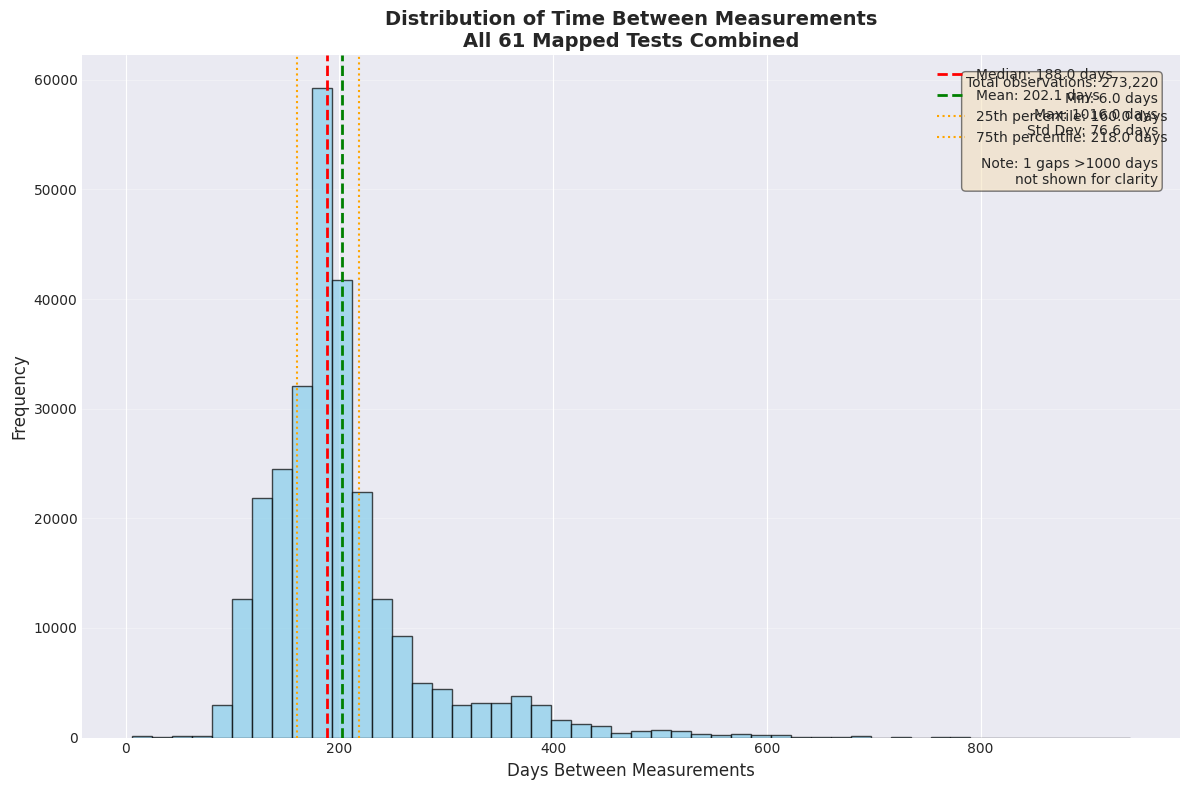


✅ Time gap histogram saved to /home/ubuntu/data/function_health/time_gaps_all_mapped_tests.png

📊 Time Gap Statistics (in days):
Mean: 202.1
Median: 188.0
Standard Deviation: 76.6
Min: 6.0
Max: 1016.0
25th percentile: 160.0
75th percentile: 218.0

⏱️ Common Time Intervals:
Within 1 month: 118 (0.0%)
1-3 months: 612 (0.2%)
3-6 months: 106,683 (39.0%)
6-12 months: 152,282 (55.7%)
1-2 years: 13,426 (4.9%)
Over 2 years: 99 (0.0%)


In [ ]:
# Create a histogram of time gaps between measurements for ALL mapped tests
import matplotlib.pyplot as plt
import seaborn as sns

print("Calculating time gaps between measurements for all mapped tests...")

# Load the patient counts mapping file if not already loaded
if 'mapping_info_df' not in locals():
    patient_counts_mapping_file = '/home/ubuntu/data/function_health/patient_counts_by_test.csv'
    if os.path.exists(patient_counts_mapping_file):
        mapping_info_df = pd.read_csv(patient_counts_mapping_file)

# Collect all time gaps across all mapped tests
all_time_gaps = []
tests_processed = 0
patients_with_multiple_measurements = 0

for idx, row in mapping_info_df.iterrows():
    chem_col = row['Chemistry Column']
    
    # Check if this column exists in chemistry data
    if chem_col in chemistry_df.columns:
        # Get data for this test
        test_data = chemistry_df[chemistry_df[chem_col].notna()].copy()
        
        if len(test_data) > 0:
            # Convert days_since_first_draw to numeric
            test_data['days_since_first_draw'] = pd.to_numeric(test_data['days_since_first_draw'], errors='coerce')
            
            # Group patients by number of measurements
            patient_counts = test_data.groupby('public_client_id').size()
            multiple_measurement_patients = patient_counts[patient_counts > 1].index
            
            if len(multiple_measurement_patients) > 0:
                multi_test_data = test_data[test_data['public_client_id'].isin(multiple_measurement_patients)]
                
                # Calculate time gaps between measurements for each patient
                for patient_id in multiple_measurement_patients:
                    patient_data = multi_test_data[multi_test_data['public_client_id'] == patient_id].sort_values('days_since_first_draw')
                    if len(patient_data) > 1:
                        gaps = patient_data['days_since_first_draw'].diff().dropna()
                        all_time_gaps.extend(gaps.tolist())
                
                tests_processed += 1
                patients_with_multiple_measurements += len(multiple_measurement_patients)

print(f"Processed {tests_processed} tests with longitudinal data")
print(f"Total patients with multiple measurements: {patients_with_multiple_measurements:,}")
print(f"Total time gaps calculated: {len(all_time_gaps):,}")



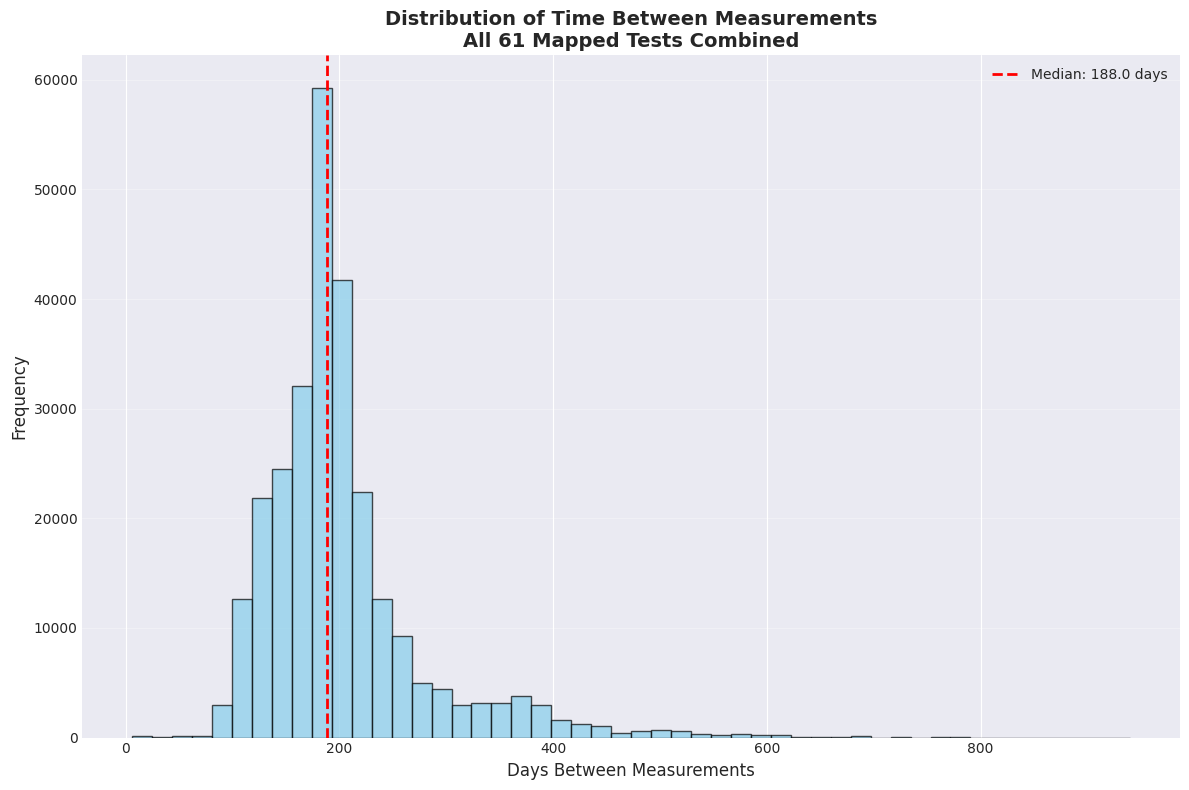


✅ Time gap histogram saved to /home/ubuntu/data/function_health/time_gaps_all_mapped_tests.png

📊 Time Gap Statistics (in days):
Mean: 202.1
Median: 188.0
Standard Deviation: 76.6
Min: 6.0
Max: 1016.0
25th percentile: 160.0
75th percentile: 218.0

⏱️ Common Time Intervals:
Within 1 month: 118 (0.0%)
1-3 months: 612 (0.2%)
3-6 months: 106,683 (39.0%)
6-12 months: 152,282 (55.7%)
1-2 years: 13,426 (4.9%)
Over 2 years: 99 (0.0%)


In [18]:
# Create the histogram
if all_time_gaps:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Convert to numpy array for easier manipulation
    time_gaps_array = np.array(all_time_gaps)
    
    # Remove outliers for better visualization (e.g., gaps > 1000 days)
    time_gaps_filtered = time_gaps_array[time_gaps_array <= 1000]
    outliers_removed = len(time_gaps_array) - len(time_gaps_filtered)
    
    # Create histogram
    n, bins, patches = ax.hist(time_gaps_filtered, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    
    # Calculate statistics
    mean_gap = np.mean(time_gaps_array)
    median_gap = np.median(time_gaps_array)
    percentile_25 = np.percentile(time_gaps_array, 25)
    percentile_75 = np.percentile(time_gaps_array, 75)
    
    # Add vertical lines for key statistics
    ax.axvline(median_gap, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_gap:.1f} days')
    #ax.axvline(mean_gap, color='green', linestyle='dashed', linewidth=2, label=f'Mean: {mean_gap:.1f} days')
    #ax.axvline(percentile_25, color='orange', linestyle='dotted', linewidth=1.5, label=f'25th percentile: {percentile_25:.1f} days')
    #ax.axvline(percentile_75, color='orange', linestyle='dotted', linewidth=1.5, label=f'75th percentile: {percentile_75:.1f} days')
    
    # Customize the plot
    ax.set_xlabel('Days Between Measurements', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Distribution of Time Between Measurements\nAll {tests_processed} Mapped Tests Combined', 
                 fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.legend(loc='upper right')
    
    # Add text box with summary statistics
    #stats_text = f'Total observations: {len(all_time_gaps):,}\n'
    #stats_text += f'Min: {np.min(time_gaps_array):.1f} days\n'
    #stats_text += f'Max: {np.max(time_gaps_array):.1f} days\n'
    #stats_text += f'Std Dev: {np.std(time_gaps_array):.1f} days'
    #if outliers_removed > 0:
    #    stats_text += f'\n\nNote: {outliers_removed:,} gaps >1000 days\nnot shown for clarity'
    
    #ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, 
    #        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
    #        verticalalignment='top', horizontalalignment='right', fontsize=10)
    
    plt.tight_layout()
    
    # Save the plot
    output_file = os.path.join(output_dir, 'time_gaps_all_mapped_tests.png')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Time gap histogram saved to {output_file}")
    
    # Print detailed statistics
    print("\n📊 Time Gap Statistics (in days):")
    print(f"Mean: {mean_gap:.1f}")
    print(f"Median: {median_gap:.1f}")
    print(f"Standard Deviation: {np.std(time_gaps_array):.1f}")
    print(f"Min: {np.min(time_gaps_array):.1f}")
    print(f"Max: {np.max(time_gaps_array):.1f}")
    print(f"25th percentile: {percentile_25:.1f}")
    print(f"75th percentile: {percentile_75:.1f}")
    
    # Common time intervals
    print("\n⏱️ Common Time Intervals:")
    common_intervals = [
        (0, 30, "Within 1 month"),
        (30, 90, "1-3 months"),
        (90, 180, "3-6 months"),
        (180, 365, "6-12 months"),
        (365, 730, "1-2 years"),
        (730, float('inf'), "Over 2 years")
    ]
    
    for start, end, label in common_intervals:
        count = np.sum((time_gaps_array >= start) & (time_gaps_array < end))
        percentage = count / len(time_gaps_array) * 100
        print(f"{label}: {count:,} ({percentage:.1f}%)")
else:
    print("\nNo time gap data available for mapped tests.")

## 📊 Longitudinal Patterns - All Mapped Tests

Creating longitudinal analysis for all mapped tests...
Analyzed 61 mapped tests


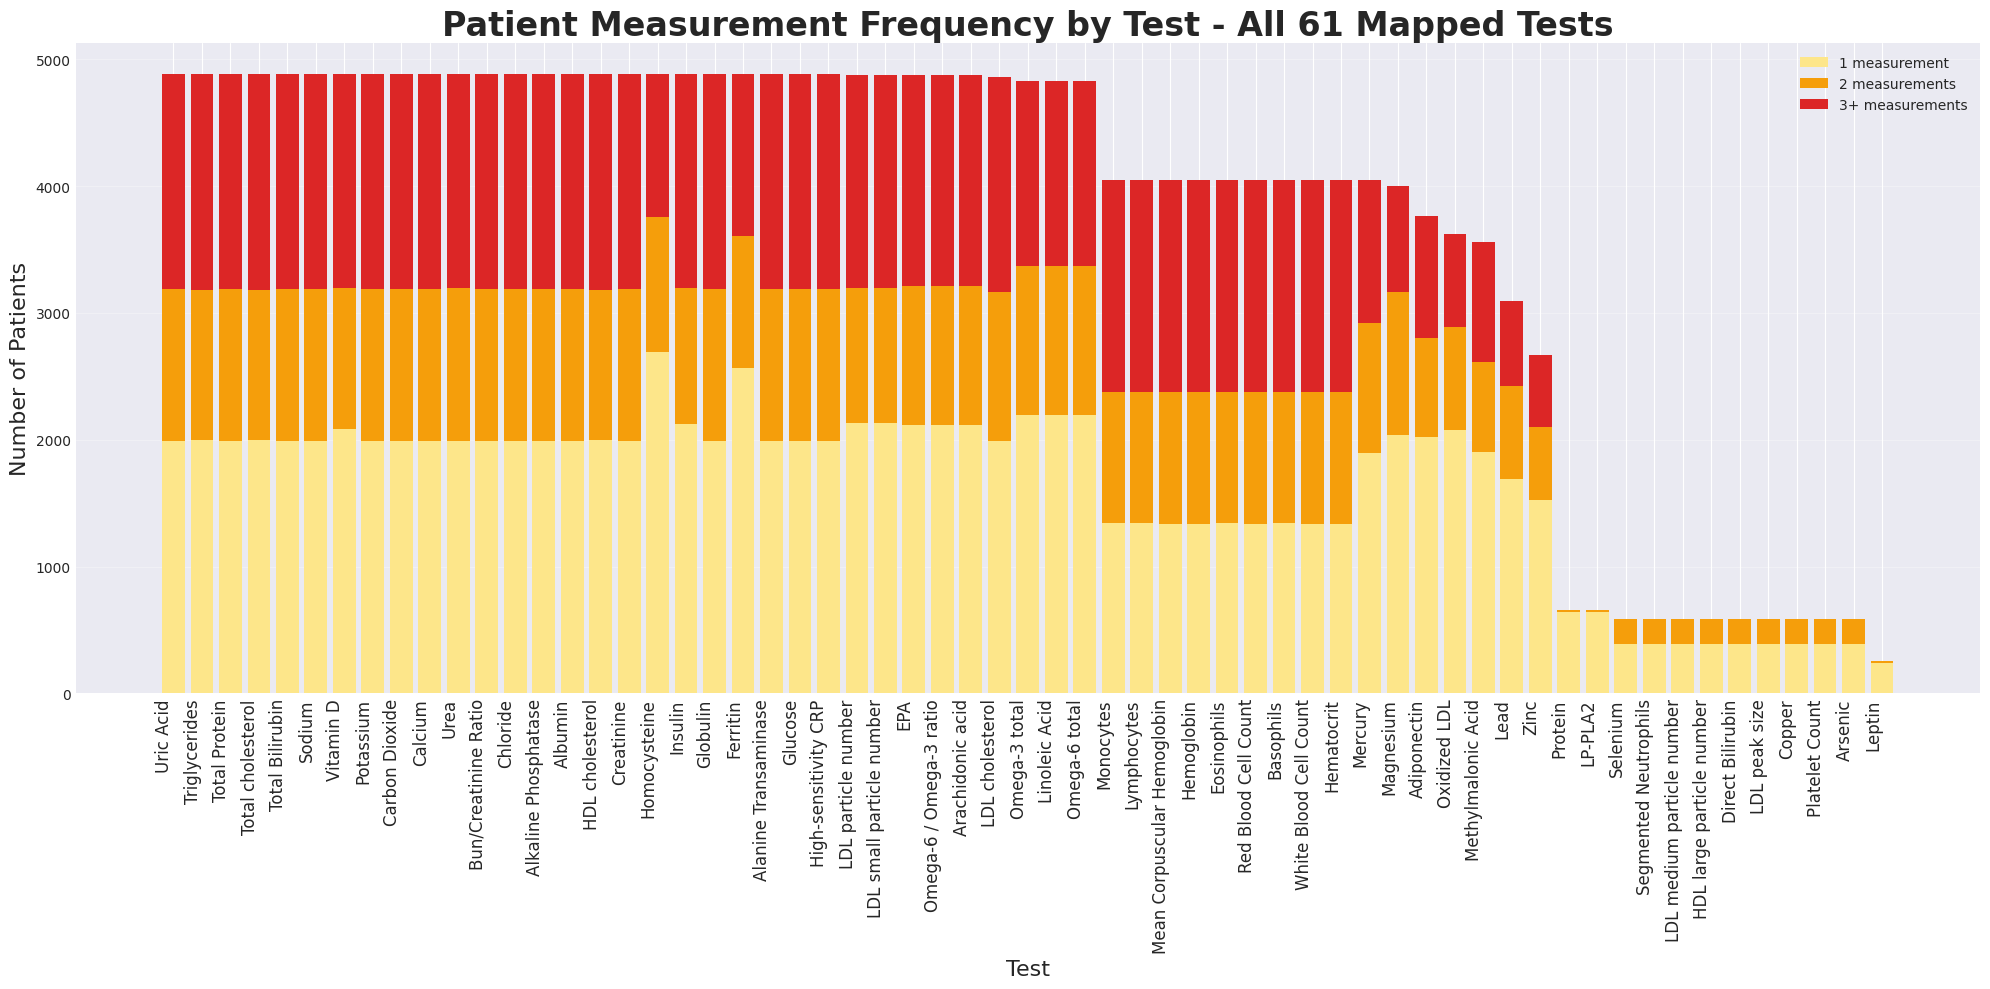


✅ Stacked bar chart saved to /home/ubuntu/data/function_health/longitudinal_patterns_all_mapped_tests.png

📊 Summary Statistics for All Mapped Tests:
Total tests analyzed: 61
Tests with >50% single measurements: 20
Tests with >30% patients having 3+ measurements: 40

🔄 Top 10 Tests by Repeat Measurement Rate:
Mean Corpuscular Hemoglobin: 67.0% repeat rate (4,051 total patients)
Hemoglobin: 67.0% repeat rate (4,051 total patients)
Red Blood Cell Count: 67.0% repeat rate (4,051 total patients)
White Blood Cell Count: 67.0% repeat rate (4,051 total patients)
Hematocrit: 67.0% repeat rate (4,051 total patients)
Monocytes: 66.9% repeat rate (4,051 total patients)
Lymphocytes: 66.9% repeat rate (4,051 total patients)
Eosinophils: 66.9% repeat rate (4,051 total patients)
Basophils: 66.9% repeat rate (4,051 total patients)
High-sensitivity CRP: 59.2% repeat rate (4,881 total patients)


In [20]:
# Create a stacked bar chart for ALL mapped tests
import matplotlib.pyplot as plt
import seaborn as sns

print("Creating longitudinal analysis for all mapped tests...")

# Load the patient counts mapping file if not already loaded
if 'mapping_info_df' not in locals():
    patient_counts_mapping_file = '/home/ubuntu/data/function_health/patient_counts_by_test.csv'
    if os.path.exists(patient_counts_mapping_file):
        mapping_info_df = pd.read_csv(patient_counts_mapping_file)
        print(f"Loaded mapping info with {len(mapping_info_df)} tests")

# Calculate longitudinal patterns for all mapped tests
mapped_longitudinal_analysis = []

for idx, row in mapping_info_df.iterrows():
    chem_col = row['Chemistry Column']
    display_name = row['Display Name']
    
    # Check if this column exists in chemistry data
    if chem_col in chemistry_df.columns:
        # Get non-null values for this test
        test_data = chemistry_df[chemistry_df[chem_col].notna()]
        
        if len(test_data) > 0:
            # Count measurements per patient
            patient_measurement_counts = test_data.groupby('public_client_id').size()
            
            # Calculate statistics
            stats = {
                'Test': display_name,
                'Chemistry Column': chem_col,
                'Total Patients': len(patient_measurement_counts),
                'Patients with 1 measurement': (patient_measurement_counts == 1).sum(),
                'Patients with 2 measurements': (patient_measurement_counts == 2).sum(),
                'Patients with 3+ measurements': (patient_measurement_counts >= 3).sum(),
                'Max measurements per patient': patient_measurement_counts.max(),
                'Median measurements per patient': patient_measurement_counts.median()
            }
            
            mapped_longitudinal_analysis.append(stats)

# Create DataFrame from results
mapped_longitudinal_df = pd.DataFrame(mapped_longitudinal_analysis)

# Sort by total patients (descending)
mapped_longitudinal_df = mapped_longitudinal_df.sort_values('Total Patients', ascending=False)

print(f"Analyzed {len(mapped_longitudinal_df)} mapped tests")

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(20, 10))

tests = mapped_longitudinal_df['Test']
single = mapped_longitudinal_df['Patients with 1 measurement']
double = mapped_longitudinal_df['Patients with 2 measurements']
triple_plus = mapped_longitudinal_df['Patients with 3+ measurements']

x = range(len(tests))
width = 0.8

# Create stacked bars
p1 = ax.bar(x, single, width, label='1 measurement', color='#fde68a')
p2 = ax.bar(x, double, width, bottom=single, label='2 measurements', color='#f59e0b')
p3 = ax.bar(x, triple_plus, width, bottom=single+double, label='3+ measurements', color='#dc2626')

# Customize the plot
ax.set_xlabel('Test', fontsize=16)
ax.set_ylabel('Number of Patients', fontsize=16)
ax.set_title(f'Patient Measurement Frequency by Test - All {len(tests)} Mapped Tests', fontsize=24, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(tests, rotation=90, ha='right', fontsize=12)
ax.legend(loc='upper right')

# Add grid for better readability
ax.grid(axis='y', alpha=0.3)

# Add vertical lines every 10 tests for easier reading
#for i in range(10, len(tests), 10):
#    ax.axvline(x=i-0.5, color='gray', linewidth=0.5, alpha=0.5, linestyle='--')

plt.tight_layout()

# Save the plot
output_file = os.path.join(output_dir, 'longitudinal_patterns_all_mapped_tests.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Stacked bar chart saved to {output_file}")

# Print summary statistics
print("\n📊 Summary Statistics for All Mapped Tests:")
print(f"Total tests analyzed: {len(mapped_longitudinal_df)}")
print(f"Tests with >50% single measurements: {len(mapped_longitudinal_df[mapped_longitudinal_df['Patients with 1 measurement'] / mapped_longitudinal_df['Total Patients'] > 0.5])}")
print(f"Tests with >30% patients having 3+ measurements: {len(mapped_longitudinal_df[mapped_longitudinal_df['Patients with 3+ measurements'] / mapped_longitudinal_df['Total Patients'] > 0.3])}")

# Show top 10 tests by repeat measurement rate
print("\n🔄 Top 10 Tests by Repeat Measurement Rate:")
mapped_longitudinal_df['Repeat Rate %'] = ((mapped_longitudinal_df['Patients with 2 measurements'] + 
                                            mapped_longitudinal_df['Patients with 3+ measurements']) / 
                                           mapped_longitudinal_df['Total Patients'] * 100)

top_repeat_tests = mapped_longitudinal_df.nlargest(10, 'Repeat Rate %')
for idx, row in top_repeat_tests.iterrows():
    print(f"{row['Test']}: {row['Repeat Rate %']:.1f}% repeat rate ({row['Total Patients']:,} total patients)")

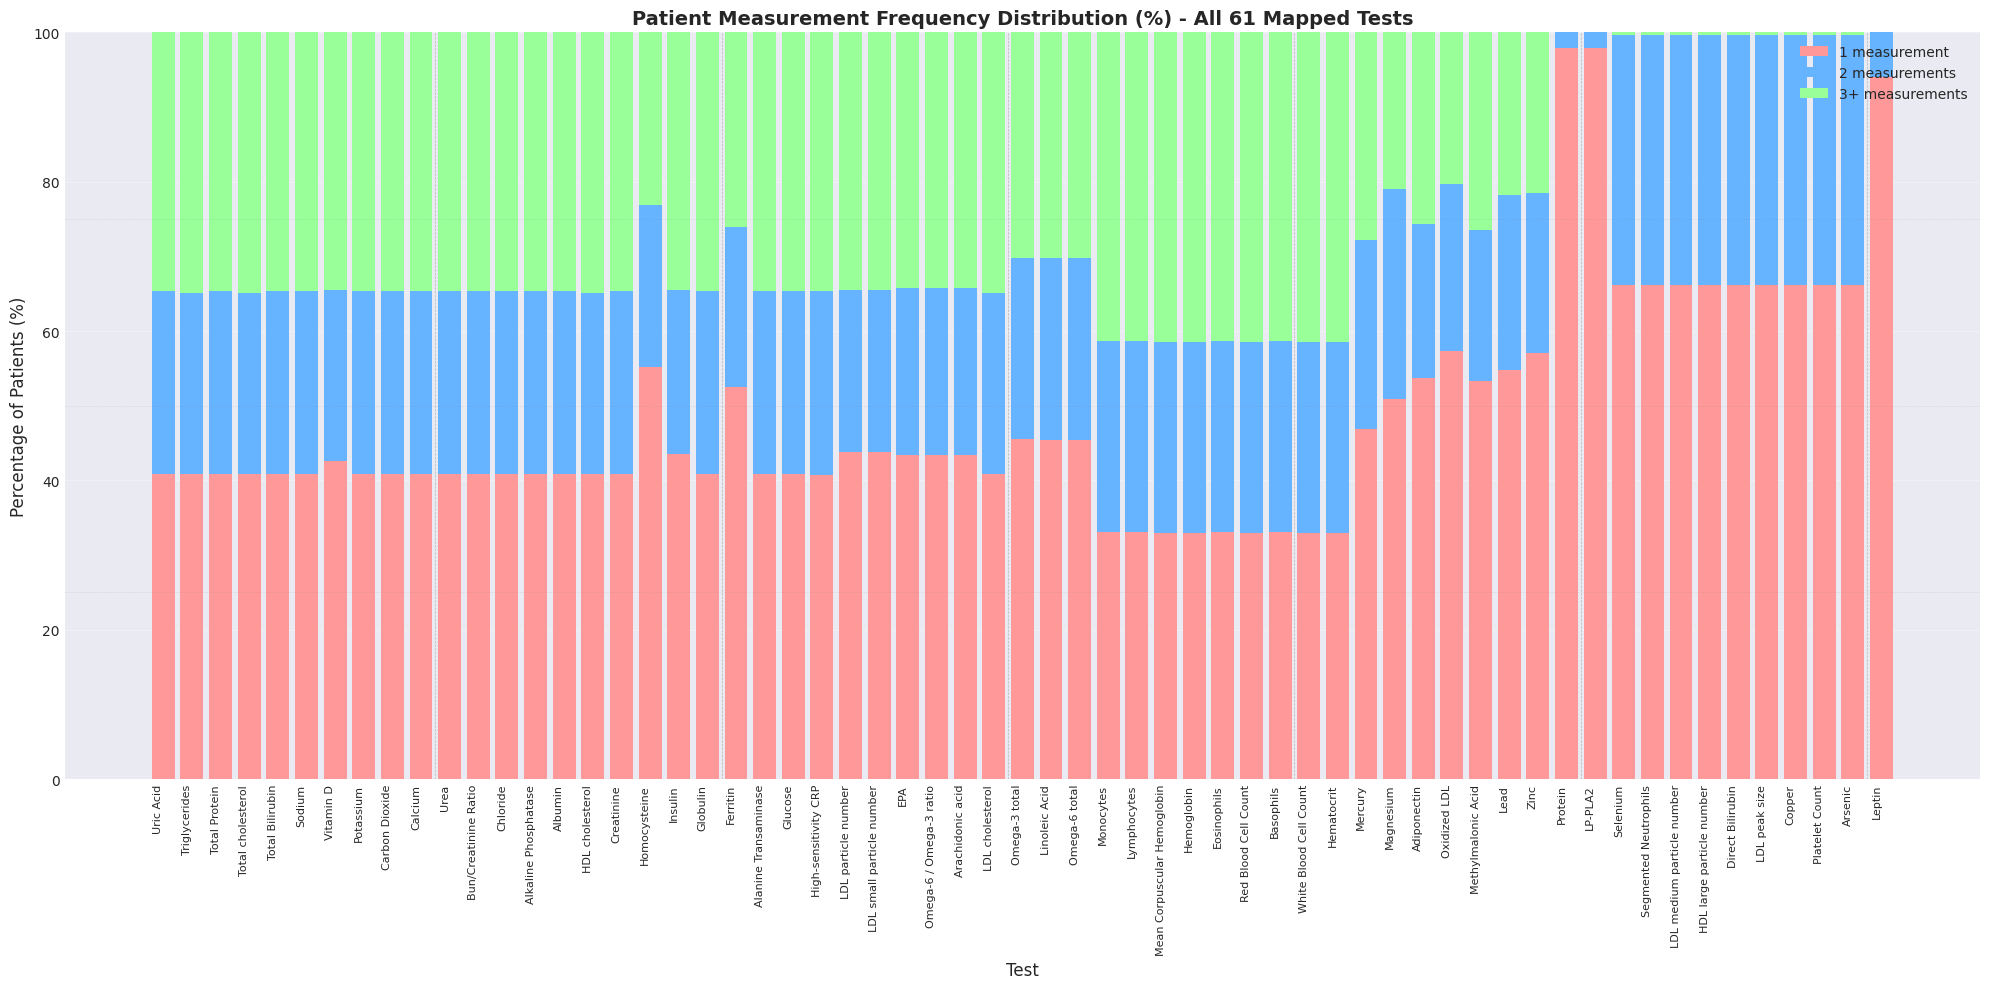


✅ Normalized stacked bar chart saved to /home/ubuntu/data/function_health/longitudinal_patterns_normalized_all_mapped_tests.png
📊 Longitudinal analysis data saved to /home/ubuntu/data/function_health/mapped_tests_longitudinal_analysis.csv

📈 Tests Grouped by Measurement Patterns:

1️⃣ High Single Measurement Tests (>70% single): 3
   - Protein: 97.9% single measurement
   - LP-PLA2: 97.9% single measurement
   - Leptin: 94.0% single measurement

⚖️  Balanced Measurement Tests (30-70% single): 58
   - Uric Acid: 59.2% repeat rate
   - Triglycerides: 59.1% repeat rate
   - Total Protein: 59.2% repeat rate
   - Total cholesterol: 59.1% repeat rate
   - Total Bilirubin: 59.2% repeat rate

🔄 High Repeat Measurement Tests (<30% single): 0


In [11]:
# Create a normalized stacked bar chart showing percentages
fig, ax = plt.subplots(figsize=(20, 10))

# Calculate percentages
total_patients = mapped_longitudinal_df['Total Patients']
single_pct = (mapped_longitudinal_df['Patients with 1 measurement'] / total_patients * 100)
double_pct = (mapped_longitudinal_df['Patients with 2 measurements'] / total_patients * 100)
triple_plus_pct = (mapped_longitudinal_df['Patients with 3+ measurements'] / total_patients * 100)

x = range(len(tests))
width = 0.8

# Create normalized stacked bars (percentages)
p1 = ax.bar(x, single_pct, width, label='1 measurement', color='#ff9999')
p2 = ax.bar(x, double_pct, width, bottom=single_pct, label='2 measurements', color='#66b3ff')
p3 = ax.bar(x, triple_plus_pct, width, bottom=single_pct+double_pct, label='3+ measurements', color='#99ff99')

# Customize the plot
ax.set_xlabel('Test', fontsize=12)
ax.set_ylabel('Percentage of Patients (%)', fontsize=12)
ax.set_title(f'Patient Measurement Frequency Distribution (%) - All {len(tests)} Mapped Tests', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(tests, rotation=90, ha='right', fontsize=8)
ax.set_ylim(0, 100)
ax.legend(loc='upper right')

# Add grid for better readability
ax.grid(axis='y', alpha=0.3)

# Add horizontal lines at key percentages
for y in [25, 50, 75]:
    ax.axhline(y=y, color='gray', linewidth=0.5, alpha=0.3, linestyle=':')

# Add vertical lines every 10 tests
for i in range(10, len(tests), 10):
    ax.axvline(x=i-0.5, color='gray', linewidth=0.5, alpha=0.5, linestyle='--')

plt.tight_layout()

# Save the normalized plot
output_file = os.path.join(output_dir, 'longitudinal_patterns_normalized_all_mapped_tests.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Normalized stacked bar chart saved to {output_file}")

# Save the longitudinal analysis data
mapped_longitudinal_df.to_csv(os.path.join(output_dir, 'mapped_tests_longitudinal_analysis.csv'), index=False)
print(f"📊 Longitudinal analysis data saved to {os.path.join(output_dir, 'mapped_tests_longitudinal_analysis.csv')}")

# Group tests by measurement patterns
print("\n📈 Tests Grouped by Measurement Patterns:")

# High single measurement tests (>70% single)
high_single = mapped_longitudinal_df[single_pct > 70]
print(f"\n1️⃣ High Single Measurement Tests (>70% single): {len(high_single)}")
if len(high_single) > 0:
    for _, row in high_single.head(5).iterrows():
        single_rate = row['Patients with 1 measurement'] / row['Total Patients'] * 100
        print(f"   - {row['Test']}: {single_rate:.1f}% single measurement")

# Balanced tests (30-70% single)
balanced = mapped_longitudinal_df[(single_pct >= 30) & (single_pct <= 70)]
print(f"\n⚖️  Balanced Measurement Tests (30-70% single): {len(balanced)}")
if len(balanced) > 0:
    for _, row in balanced.head(5).iterrows():
        repeat_rate = row['Repeat Rate %']
        print(f"   - {row['Test']}: {repeat_rate:.1f}% repeat rate")

# High repeat tests (<30% single)
high_repeat = mapped_longitudinal_df[single_pct < 30]
print(f"\n🔄 High Repeat Measurement Tests (<30% single): {len(high_repeat)}")
if len(high_repeat) > 0:
    for _, row in high_repeat.head(5).iterrows():
        repeat_rate = row['Repeat Rate %']
        print(f"   - {row['Test']}: {repeat_rate:.1f}% repeat rate")

In [12]:
# Compare with the mapping-based results to understand discrepancies
print("Comparing direct chemistry analysis with mapping-based results...")

# Load the mapping results for comparison
mapping_results_file = '/home/ubuntu/data/function_health/patient_counts_by_test.csv'
if os.path.exists(mapping_results_file):
    mapping_df = pd.read_csv(mapping_results_file)
    
    # Find tests that appear in both analyses
    direct_test_names = set(patient_counts_df['Test Name'].str.upper())
    mapping_test_names = set(mapping_df['Chemistry Column'].str.upper())
    
    common_tests = direct_test_names.intersection(mapping_test_names)
    print(f"\nTests found in both analyses: {len(common_tests)}")
    
    # Compare patient counts for common tests
    print("\nPatient count comparison (top 10 common tests):")
    comparison_data = []
    
    for test in list(common_tests)[:10]:
        # Find in direct analysis
        direct_row = patient_counts_df[patient_counts_df['Test Name'].str.upper() == test]
        if not direct_row.empty:
            direct_count = direct_row.iloc[0]['Unique Patients']
            
            # Find in mapping analysis
            mapping_row = mapping_df[mapping_df['Chemistry Column'].str.upper() == test]
            if not mapping_row.empty:
                mapping_count = mapping_row.iloc[0]['Unique Patients']
                
                comparison_data.append({
                    'Test': test,
                    'Direct Analysis Count': direct_count,
                    'Mapping Analysis Count': mapping_count,
                    'Difference': direct_count - mapping_count
                })
    
    if comparison_data:
        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df)
else:
    print(f"\nMapping results file not found at {mapping_results_file}")

Comparing direct chemistry analysis with mapping-based results...

Tests found in both analyses: 61

Patient count comparison (top 10 common tests):
                   Test  Direct Analysis Count  Mapping Analysis Count  \
0               GLUCOSE                   4881                    4881   
1    ADIPONECTIN, SERUM                   3764                    3764   
2               PROTEIN                    658                     658   
3        MERCURY, BLOOD                   4048                    4048   
4  VITAMIN D, 25-OH TOT                   4881                    4881   
5        RED CELL COUNT                   4051                    4051   
6       HDL CHOL DIRECT                   4881                    4881   
7      MAGNESIUM, SERUM                   4003                    4003   
8              CHLORIDE                   4881                    4881   
9             BASOPHILS                   4051                    4051   

   Difference  
0           0  
1   

In [13]:
# Save all analysis results
print("\nSaving analysis results...")

# Check dependencies
if 'patient_counts_df' not in locals():
    print("ERROR: Please run cell 8 first to create patient_counts_df")
elif 'all_test_columns' not in locals():
    print("ERROR: Please run cell 6 first to identify test columns")
elif 'chemistry_df' not in locals():
    print("ERROR: Please run cell 4 first to load chemistry_df")
else:
    # Make sure output_dir exists
    if 'output_dir' not in locals():
        output_dir = '/home/ubuntu/data/function_health'
        os.makedirs(output_dir, exist_ok=True)
    
    # Save patient counts
    patient_counts_df.to_csv(os.path.join(output_dir, 'direct_patient_counts.csv'), index=False)
    print(f"Patient counts saved to {os.path.join(output_dir, 'direct_patient_counts.csv')}")
    
    # Save longitudinal analysis if available
    if 'longitudinal_df' in locals():
        longitudinal_df.to_csv(os.path.join(output_dir, 'longitudinal_analysis.csv'), index=False)
        print(f"Longitudinal analysis saved to {os.path.join(output_dir, 'longitudinal_analysis.csv')}")
    
    # Create summary report
    summary_lines = [
        "# Arivale Chemistry Patient Analysis Summary",
        f"\nAnalysis Date: {pd.Timestamp.now()}",
        f"\nTotal unique patients in dataset: {chemistry_df['public_client_id'].nunique()}",
        f"Total chemistry records: {len(chemistry_df)}",
        f"\nNumber of test columns analyzed: {len(all_test_columns)}",
        f"Tests with data: {len(patient_counts_df)}",
        f"\nTests with most patients:",
        patient_counts_df.head(10).to_string(),
        f"\n\nTests with fewest patients (non-zero):",
        patient_counts_df[patient_counts_df['Unique Patients'] > 0].tail(10).to_string(),
        f"\n\nKey Findings:",
        f"- Most common tests have around {patient_counts_df.iloc[0]['Unique Patients']} unique patients",
        f"- Average measurements per patient ranges from {patient_counts_df['Avg Measurements per Patient'].min():.2f} to {patient_counts_df['Avg Measurements per Patient'].max():.2f}",
        f"- {len(patient_counts_df[patient_counts_df['Unique Patients'] < 100])} tests have fewer than 100 patients"
    ]
    
    with open(os.path.join(output_dir, 'analysis_summary.txt'), 'w') as f:
        f.write('\n'.join(summary_lines))
    
    print(f"\nSummary report saved to {os.path.join(output_dir, 'analysis_summary.txt')}")
    print("\nAnalysis complete!")


Saving analysis results...
Patient counts saved to /home/ubuntu/data/function_health/direct_patient_counts.csv
Longitudinal analysis saved to /home/ubuntu/data/function_health/longitudinal_analysis.csv

Summary report saved to /home/ubuntu/data/function_health/analysis_summary.txt

Analysis complete!


## 📊 Observation Count Heatmap - Mapped Tests Only

Loaded mapping info with 61 tests

📊 Calculating observation counts for mapped tests...


📊 Included 61 mapped tests with data


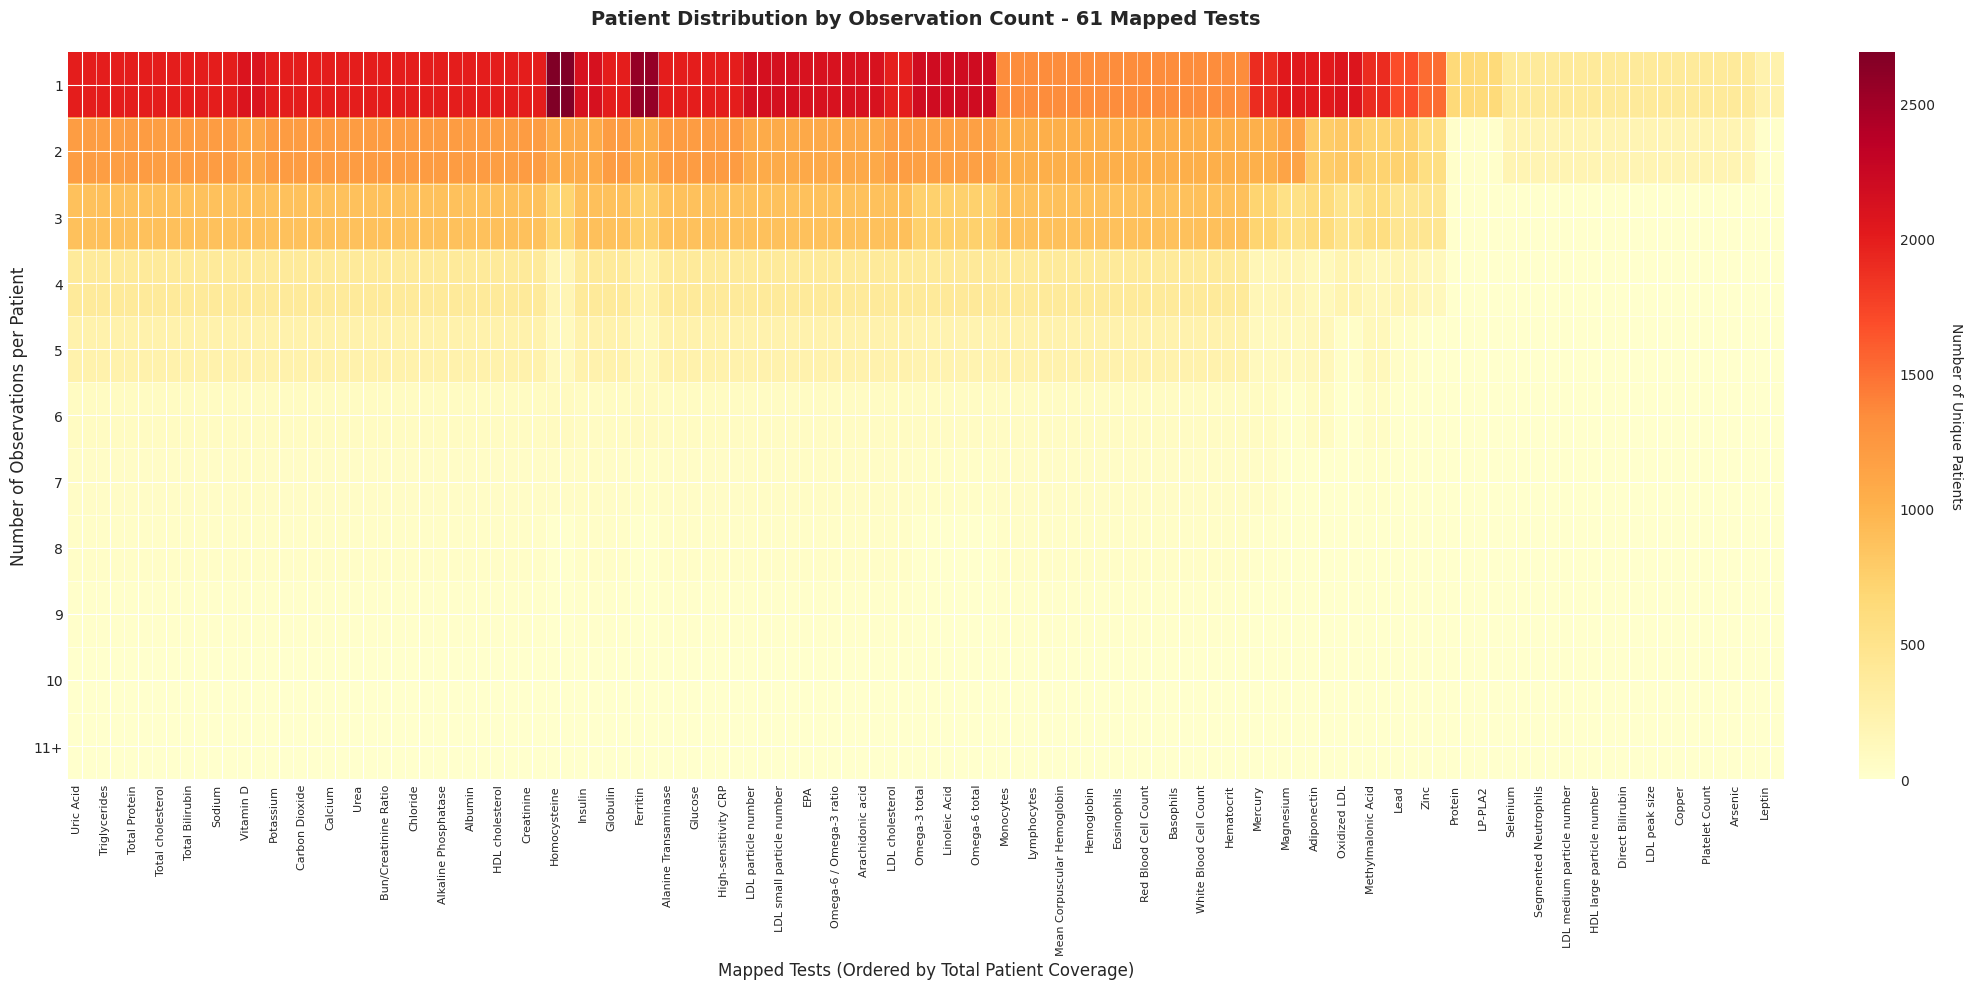


✅ Heatmap saved to /home/ubuntu/data/function_health/observation_count_heatmap_mapped_tests.png


In [14]:
# Load the patient counts file which has the mapping information
patient_counts_mapping_file = '/home/ubuntu/data/function_health/patient_counts_by_test.csv'

# This file has the chemistry column names and display names
mapping_info_df = pd.read_csv(patient_counts_mapping_file)
print(f"Loaded mapping info with {len(mapping_info_df)} tests")

# Create comprehensive observation count heatmap for MAPPED tests only
fig, ax = plt.subplots(figsize=(20, 10))

# Define observation count bins (1st, 2nd, 3rd, etc.)
max_observations = 10  # Show up to 10th observation, group rest as "11+"
obs_labels = [f'{i}' for i in range(1, max_observations + 1)] + ['11+']

# Calculate observation counts for mapped tests only
print("\n📊 Calculating observation counts for mapped tests...")
all_obs_data = []
test_names_for_heatmap = []
test_display_names = []

# Process each mapped test
for idx, row in mapping_info_df.iterrows():
    chem_col = row['Chemistry Column']
    display_name = row['Display Name']
    
    # Check if this column exists in chemistry data
    if chem_col in chemistry_df.columns:
        # Get data for this test
        test_data = chemistry_df[chemistry_df[chem_col].notna()]
        
        if len(test_data) > 0:  # Only include if there's data
            test_names_for_heatmap.append(chem_col)
            test_display_names.append(display_name)
            
            # Count observations per patient
            patient_obs_counts = test_data.groupby('public_client_id').size()
            
            # Bin the observation counts
            obs_bins = []
            for i in range(1, max_observations + 1):
                obs_bins.append((patient_obs_counts == i).sum())
            # Add 11+ category
            obs_bins.append((patient_obs_counts > max_observations).sum())
            
            all_obs_data.append(obs_bins)

print(f"📊 Included {len(test_names_for_heatmap)} mapped tests with data")

# Sort tests by total patient count (descending)
total_patients_per_test = [sum(obs_data) for obs_data in all_obs_data]
sorted_indices = sorted(range(len(total_patients_per_test)), 
                        key=lambda i: total_patients_per_test[i], 
                        reverse=True)

# Reorder data based on patient count
test_names_sorted = [test_names_for_heatmap[i] for i in sorted_indices]
test_display_names_sorted = [test_display_names[i] for i in sorted_indices]
all_obs_data_sorted = [all_obs_data[i] for i in sorted_indices]

# Transpose data so tests are on x-axis and observations on y-axis
all_obs_data_transposed = np.array(all_obs_data_sorted).T

# Create the heatmap with swapped axes
im = ax.imshow(all_obs_data_transposed, cmap='YlOrRd', aspect='auto', interpolation='nearest')

# Set ticks and labels - use display names for better readability
ax.set_xticks(range(len(test_display_names_sorted)))
ax.set_xticklabels(test_display_names_sorted, rotation=90, ha='right', fontsize=8)
ax.set_yticks(range(len(obs_labels)))
ax.set_yticklabels(obs_labels, fontsize=10)

# Force matplotlib to show all x-axis labels
#ax.xaxis.set_tick_params(which='major', labelbottom=True)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, ha='right')

# Add labels
ax.set_xlabel('Mapped Tests (Ordered by Total Patient Coverage)', fontsize=12)
ax.set_ylabel('Number of Observations per Patient', fontsize=12)
ax.set_title(f'Patient Distribution by Observation Count - {len(test_names_sorted)} Mapped Tests', 
                fontsize=14, fontweight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Number of Unique Patients', rotation=270, labelpad=20)

for i in range(1, len(test_names_sorted)):
    ax.axvline(x=i-0.5, color='white', linewidth=0.5, alpha=0.8)

for i in range(1, len(obs_labels)):
    ax.axhline(y=i-0.5, color='white', linewidth=0.5, alpha=0.8)

plt.tight_layout()

# Save the observation count heatmap
output_file = os.path.join(output_dir, 'observation_count_heatmap_mapped_tests.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Heatmap saved to {output_file}")

In [15]:
# Summary statistics by observation count for mapped tests
if 'all_obs_data_sorted' in locals():
    print("\n📊 Summary Statistics by Observation Count (Mapped Tests Only):")
    obs_totals = np.sum(all_obs_data_sorted, axis=0)
    obs_percentages = (obs_totals / obs_totals.sum() * 100)
    
    summary_df = pd.DataFrame({
        'Observation Number': obs_labels,
        'Total Patients': obs_totals,
        'Percentage': [f'{pct:.1f}%' for pct in obs_percentages],
        'Cumulative %': [f'{obs_percentages[:i+1].sum():.1f}%' for i in range(len(obs_percentages))]
    })
    print(summary_df)
    
    # Tests with highest repeat observation rates
    print(f"\n🔄 Top 10 Mapped Tests with Highest Repeat Observation Rates:")
    repeat_rates = []
    for i, (test_name, display_name, obs_data) in enumerate(zip(test_names_sorted, test_display_names_sorted, all_obs_data_sorted)):
        single_obs = obs_data[0]
        total_patients = sum(obs_data)
        if total_patients > 0:
            repeat_rate = (total_patients - single_obs) / total_patients * 100
            repeat_rates.append((display_name, test_name, repeat_rate, total_patients - single_obs, total_patients))
    
    for i, (display_name, test_name, rate, repeat_patients, total) in enumerate(sorted(repeat_rates, key=lambda x: x[2], reverse=True)[:10]):
        print(f"{i+1}. {display_name}: {rate:.1f}% ({repeat_patients:,}/{total:,} patients with 2+ observations)")
    
    # Match type analysis
    if 'mapping_info_df' in locals():
        print(f"\n📊 Observation Patterns by Match Type:")
        match_type_data = {}
        for idx, row in mapping_info_df.iterrows():
            chem_col = row['Chemistry Column']
            match_type = row['Match Type']
            
            if chem_col in test_names_for_heatmap:
                idx_in_list = test_names_for_heatmap.index(chem_col)
                obs_data = all_obs_data[idx_in_list]
                
                if match_type not in match_type_data:
                    match_type_data[match_type] = []
                match_type_data[match_type].append(obs_data)
        
        for match_type, obs_data_list in match_type_data.items():
            total_by_obs = np.sum(obs_data_list, axis=0)
            total_patients = sum(total_by_obs)
            repeat_rate = (total_patients - total_by_obs[0]) / total_patients * 100 if total_patients > 0 else 0
            print(f"\n{match_type}:")
            print(f"  - Tests: {len(obs_data_list)}")
            print(f"  - Total patient observations: {total_patients:,}")
            print(f"  - Repeat observation rate: {repeat_rate:.1f}%")


📊 Summary Statistics by Observation Count (Mapped Tests Only):
   Observation Number  Total Patients Percentage Cumulative %
0                   1           98679      43.1%        43.1%
1                   2           55261      24.1%        67.2%
2                   3           40076      17.5%        84.7%
3                   4           16914       7.4%        92.1%
4                   5           10313       4.5%        96.6%
5                   6            3338       1.5%        98.1%
6                   7            2200       1.0%        99.1%
7                   8            1392       0.6%        99.7%
8                   9             697       0.3%       100.0%
9                  10              67       0.0%       100.0%
10                11+               0       0.0%       100.0%

🔄 Top 10 Mapped Tests with Highest Repeat Observation Rates:
1. Mean Corpuscular Hemoglobin: 67.0% (2,716/4,051 patients with 2+ observations)
2. Hemoglobin: 67.0% (2,716/4,051 patients with 

## 📈 Normalized Heatmap - Mapped Tests Only

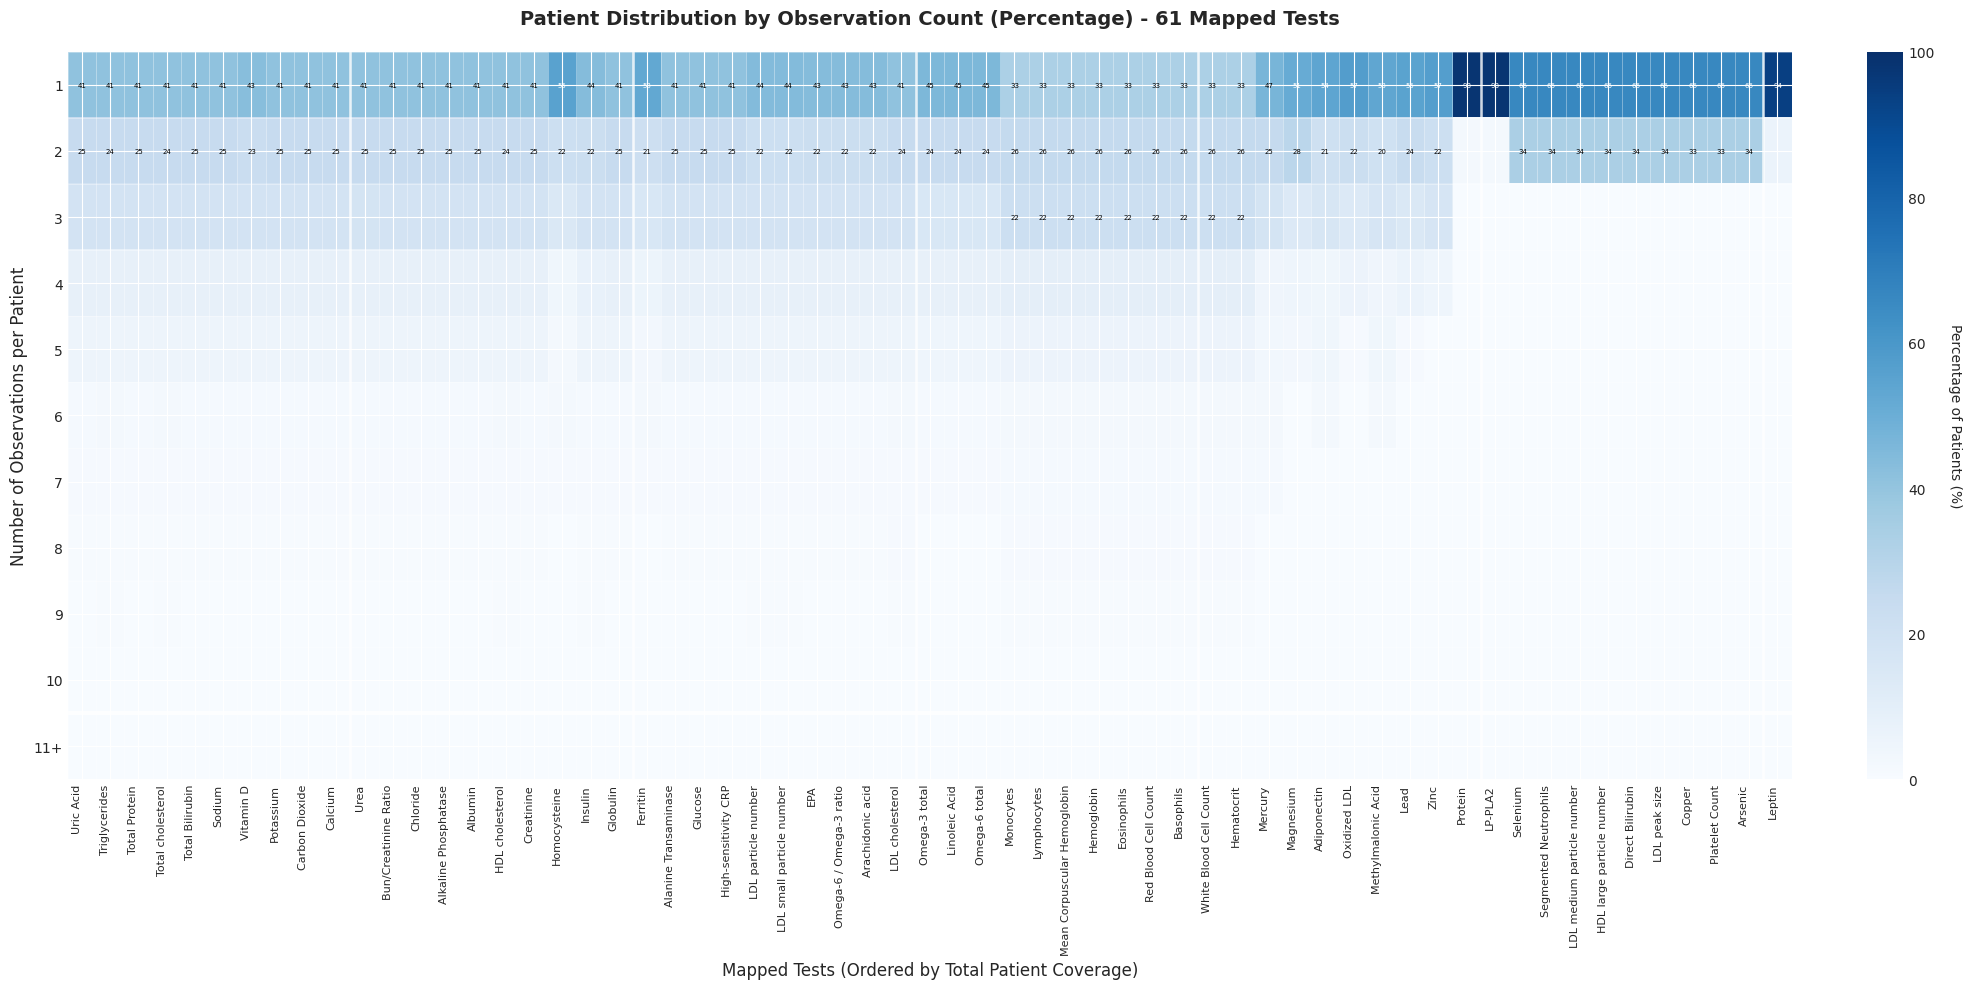


✅ Normalized heatmap saved to /home/ubuntu/data/function_health/observation_count_heatmap_normalized_mapped.png

📊 Key Statistics for Mapped Tests:
- Total mapped tests analyzed: 61
- Tests with >50% repeat observations: 41
- Tests with >70% single observation: 3

🏆 Tests with Most Longitudinal Data (>100 patients with 5+ observations):
  - Triglycerides: 429 patients
  - Total cholesterol: 429 patients
  - HDL cholesterol: 429 patients
  - Uric Acid: 428 patients
  - Total Protein: 428 patients


In [16]:
# Create a normalized heatmap showing percentages for mapped tests
if 'all_obs_data_sorted' in locals() and 'test_display_names_sorted' in locals():
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Normalize the data to show percentages instead of raw counts
    all_obs_data_normalized = []
    for obs_data in all_obs_data_sorted:
        total_patients = sum(obs_data)
        if total_patients > 0:
            normalized = [count / total_patients * 100 for count in obs_data]
        else:
            normalized = [0] * len(obs_data)
        all_obs_data_normalized.append(normalized)
    
    # Transpose for plotting
    all_obs_data_normalized_transposed = np.array(all_obs_data_normalized).T
    
    # Create the normalized heatmap
    im = ax.imshow(all_obs_data_normalized_transposed, cmap='Blues', aspect='auto', 
                   interpolation='nearest', vmin=0, vmax=100)
    
    # Set ticks and labels
    ax.set_xticks(range(len(test_display_names_sorted)))
    ax.set_xticklabels(test_display_names_sorted, rotation=90, ha='right', fontsize=8)
    ax.set_yticks(range(len(obs_labels)))
    ax.set_yticklabels(obs_labels, fontsize=10)
    
    # Force matplotlib to show all x-axis labels
    ax.xaxis.set_tick_params(which='major', labelbottom=True)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, ha='right')
    
    # Add labels
    ax.set_xlabel('Mapped Tests (Ordered by Total Patient Coverage)', fontsize=12)
    ax.set_ylabel('Number of Observations per Patient', fontsize=12)
    ax.set_title(f'Patient Distribution by Observation Count (Percentage) - {len(test_names_sorted)} Mapped Tests', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Add colorbar with percentage
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Percentage of Patients (%)', rotation=270, labelpad=20)
    
    # Add grid lines
    ax.set_xticks(np.arange(len(test_display_names_sorted) + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(len(obs_labels) + 1) - 0.5, minor=True)
    ax.grid(which='minor', color='white', linewidth=0.5, alpha=0.5)
    ax.tick_params(which='minor', size=0)
    
    # Add text annotations for values > 20%
    for i in range(len(obs_labels)):
        for j in range(len(test_display_names_sorted)):
            value = all_obs_data_normalized_transposed[i, j]
            if value > 20:  # Only show percentages above 20%
                ax.text(j, i, f'{value:.0f}', ha='center', va='center', 
                       color='white' if value > 50 else 'black', fontsize=5)
    
    # Add stronger vertical lines every 10 tests
    for i in range(10, len(test_display_names_sorted), 10):
        ax.axvline(x=i-0.5, color='white', linewidth=2, alpha=0.7)
    
    # Add stronger horizontal line to separate 11+ category
    ax.axhline(y=len(obs_labels)-1.5, color='white', linewidth=3, alpha=0.8)
    
    plt.tight_layout()
    
    # Save the normalized heatmap
    output_file = os.path.join(output_dir, 'observation_count_heatmap_normalized_mapped.png')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Normalized heatmap saved to {output_file}")
    
    # Print some interesting statistics
    print(f"\n📊 Key Statistics for Mapped Tests:")
    print(f"- Total mapped tests analyzed: {len(test_names_sorted)}")
    print(f"- Tests with >50% repeat observations: {sum(1 for r in repeat_rates if r[2] > 50)}")
    print(f"- Tests with >70% single observation: {sum(1 for norm in all_obs_data_normalized if norm[0] > 70)}")
    
    # Find tests with most longitudinal data
    max_obs_tests = []
    for i, (display_name, obs_data) in enumerate(zip(test_display_names_sorted, all_obs_data_sorted)):
        # Count patients with 5+ observations
        five_plus = sum(obs_data[4:])
        if five_plus > 100:  # Tests with >100 patients having 5+ observations
            max_obs_tests.append((display_name, five_plus))
    
    if max_obs_tests:
        print(f"\n🏆 Tests with Most Longitudinal Data (>100 patients with 5+ observations):")
        for test, count in sorted(max_obs_tests, key=lambda x: x[1], reverse=True)[:5]:
            print(f"  - {test}: {count:,} patients")
else:
    print("Please run the previous cell to generate the mapped test data first.")

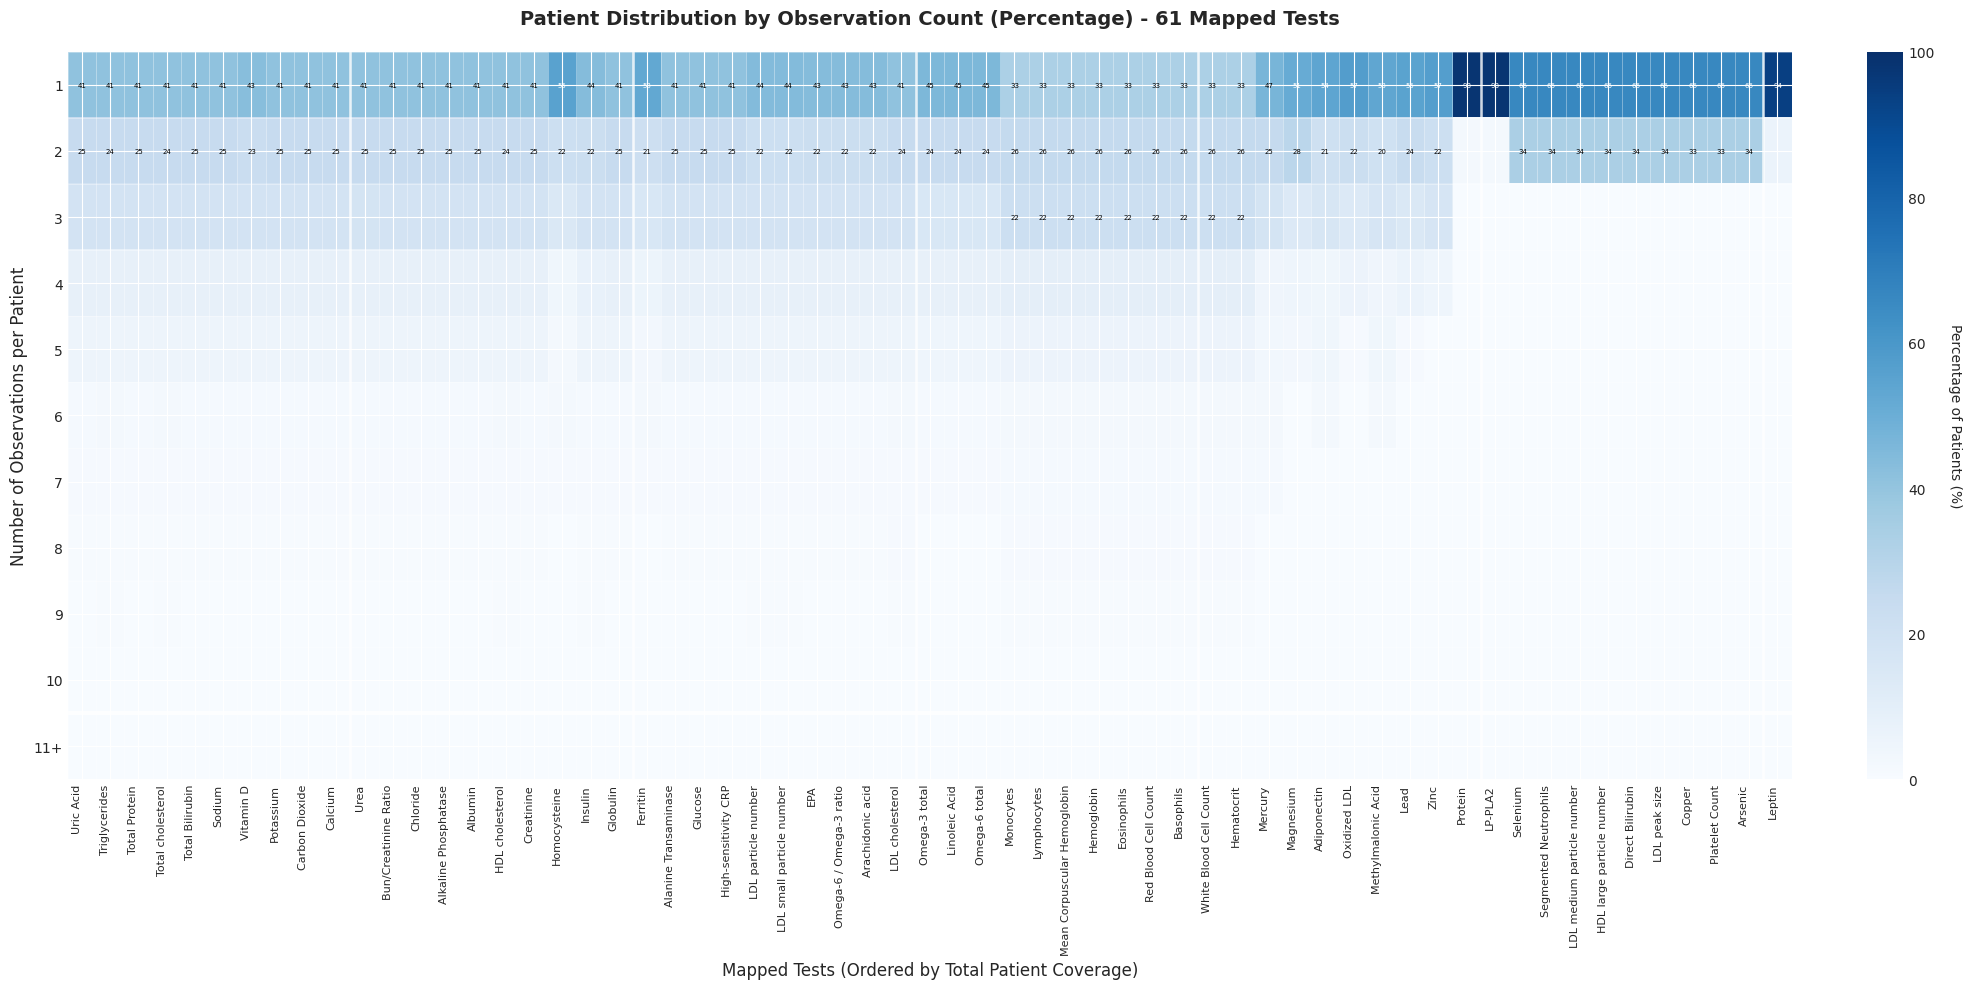


✅ Normalized heatmap saved to /home/ubuntu/data/function_health/observation_count_heatmap_normalized_mapped.png

📊 Key Statistics for Mapped Tests:
- Total mapped tests analyzed: 61
- Tests with >50% repeat observations: 41
- Tests with >70% single observation: 3

🏆 Tests with Most Longitudinal Data (>100 patients with 5+ observations):
  - Triglycerides: 429 patients
  - Total cholesterol: 429 patients
  - HDL cholesterol: 429 patients
  - Uric Acid: 428 patients
  - Total Protein: 428 patients


In [17]:
# Create a normalized heatmap showing percentages for mapped tests
fig, ax = plt.subplots(figsize=(20, 10))

# Normalize the data to show percentages instead of raw counts
all_obs_data_normalized = []
for obs_data in all_obs_data_sorted:
    total_patients = sum(obs_data)
    if total_patients > 0:
        normalized = [count / total_patients * 100 for count in obs_data]
    else:
        normalized = [0] * len(obs_data)
    all_obs_data_normalized.append(normalized)

# Transpose for plotting
all_obs_data_normalized_transposed = np.array(all_obs_data_normalized).T

# Create the normalized heatmap
im = ax.imshow(all_obs_data_normalized_transposed, cmap='Blues', aspect='auto', 
               interpolation='nearest', vmin=0, vmax=100)

# Set ticks and labels
ax.set_xticks(range(len(test_display_names_sorted)))
ax.set_xticklabels(test_display_names_sorted, rotation=90, ha='right', fontsize=8)
ax.set_yticks(range(len(obs_labels)))
ax.set_yticklabels(obs_labels, fontsize=10)

# Force matplotlib to show all x-axis labels
ax.xaxis.set_tick_params(which='major', labelbottom=True)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, ha='right')

# Add labels
ax.set_xlabel('Mapped Tests (Ordered by Total Patient Coverage)', fontsize=12)
ax.set_ylabel('Number of Observations per Patient', fontsize=12)
ax.set_title(f'Patient Distribution by Observation Count (Percentage) - {len(test_names_sorted)} Mapped Tests', 
             fontsize=14, fontweight='bold', pad=20)

# Add colorbar with percentage
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Percentage of Patients (%)', rotation=270, labelpad=20)

# Add grid lines
ax.set_xticks(np.arange(len(test_display_names_sorted) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(obs_labels) + 1) - 0.5, minor=True)
ax.grid(which='minor', color='white', linewidth=0.5, alpha=0.5)
ax.tick_params(which='minor', size=0)

# Add text annotations for values > 20%
for i in range(len(obs_labels)):
    for j in range(len(test_display_names_sorted)):
        value = all_obs_data_normalized_transposed[i, j]
        if value > 20:  # Only show percentages above 20%
            ax.text(j, i, f'{value:.0f}', ha='center', va='center', 
                   color='white' if value > 50 else 'black', fontsize=5)

# Add stronger vertical lines every 10 tests
for i in range(10, len(test_display_names_sorted), 10):
    ax.axvline(x=i-0.5, color='white', linewidth=2, alpha=0.7)

# Add stronger horizontal line to separate 11+ category
ax.axhline(y=len(obs_labels)-1.5, color='white', linewidth=3, alpha=0.8)

plt.tight_layout()

# Save the normalized heatmap
output_file = os.path.join(output_dir, 'observation_count_heatmap_normalized_mapped.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Normalized heatmap saved to {output_file}")

# Print some interesting statistics
print(f"\n📊 Key Statistics for Mapped Tests:")
print(f"- Total mapped tests analyzed: {len(test_names_sorted)}")
print(f"- Tests with >50% repeat observations: {sum(1 for r in repeat_rates if r[2] > 50)}")
print(f"- Tests with >70% single observation: {sum(1 for norm in all_obs_data_normalized if norm[0] > 70)}")

# Find tests with most longitudinal data
max_obs_tests = []
for i, (display_name, obs_data) in enumerate(zip(test_display_names_sorted, all_obs_data_sorted)):
    # Count patients with 5+ observations
    five_plus = sum(obs_data[4:])
    if five_plus > 100:  # Tests with >100 patients having 5+ observations
        max_obs_tests.append((display_name, five_plus))

if max_obs_tests:
    print(f"\n🏆 Tests with Most Longitudinal Data (>100 patients with 5+ observations):")
    for test, count in sorted(max_obs_tests, key=lambda x: x[1], reverse=True)[:5]:
        print(f"  - {test}: {count:,} patients")

## 🎯 Analysis Complete!

### 📁 Output Files Generated:
1. **Patient counts by test**: `../data/function_health/patient_counts_by_test.csv`
2. **Patient coverage visualization**: `../data/function_health/patient_coverage_analysis.png`
3. **Longitudinal analysis visualization**: `../data/function_health/longitudinal_analysis.png`
4. **Comprehensive report**: `../data/function_health/patient_analysis_report.md`

### 🔍 Key Insights:
- Patient coverage varies significantly across tests
- Some tests show strong retention with multiple measurements per patient
- Match type correlates with patient coverage patterns
- Longitudinal data reveals testing frequency and retention patterns